## Import Library

In [228]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

## Load Data

In [229]:
eda_floor = ['1F', '2F', '3F']

for floor in eda_floor:
    globals()[f'test_df_{floor}'] = pd.read_csv(f'test_df_{floor}.csv')
    globals()[f'test_df_{floor}']['시간'] = pd.to_datetime(globals()[f'test_df_{floor}']['시간'])

## Create Validation Dataset

In [230]:
for floor in eda_floor:        
    temp_df = globals()[f'test_df_{floor}'].copy()    
    temp_df['날짜'] = pd.to_datetime(temp_df['시간']).dt.normalize()
    
    ## 공조기와 냉난방기가 가동중일 때의 데이터만 필터링    
    temp_df['AHU_on'] = np.where(temp_df['급기휀상태'] > 0 , 1, 0)    

    ## 상승하는 추세의 데이터만 출력
    temp_df['temper_raise'] = np.where(temp_df['환기온도'] - temp_df['환기온도'].shift(1) > 0, 1, 0)

    ## 직전 데이터 출력
    time_temp = temp_df[(temp_df['AHU_on'] == 1) & (temp_df['temper_raise'] == 1)].groupby('날짜')['시간'].min() - datetime.timedelta(minutes = 15)
    time_temp = time_temp.reset_index()
    temp_df['temper_raise'] = np.where(temp_df['시간'].isin(time_temp['시간']), 1, temp_df['temper_raise'])
    temp_df['AHU_on'] = np.where(temp_df['시간'].isin(time_temp['시간']), 1, temp_df['AHU_on'])

    ## 감소추세 직전 데이터 필터링 (상승 후 감소하는 시점 제외)
    filter_df = pd.DataFrame()
    for date in temp_df['날짜'].unique():
        temp_df_2 = temp_df[temp_df['날짜'] == date].copy()
        temp_df_2 = temp_df_2[(temp_df_2['AHU_on'] == 1) & (temp_df_2['temper_raise'] == 1)].reset_index(drop = True)        
        temp_df_2['time_diff'] = temp_df_2['시간'] - temp_df_2['시간'].shift(1)
        
        temp_df_2['time_diff'] = temp_df_2['time_diff'].astype("timedelta64[m]")
        if temp_df_2[temp_df_2['time_diff'] > 15].shape[0] > 0:
            temp_df_2 = temp_df_2[temp_df_2['시간'] < temp_df_2[temp_df_2['time_diff'] > 15]['시간'].min()]    
        filter_df = pd.concat([filter_df, temp_df_2])    
    valid_df = pd.merge(filter_df.groupby(['날짜'])['환기온도'].min(), filter_df.groupby(['날짜'])['환기온도'].max(), left_index = True, right_index = True)
    valid_df = pd.merge(valid_df, filter_df.groupby(['날짜'])['급기휀상태'].sum(), left_index = True, right_index = True)
    valid_df.columns = ['시작온도', '목표온도', '가동시간']
    valid_df.reset_index(drop = False, inplace = True)
    globals()[f'valid_df_{floor}'] = valid_df.copy()

## Pre-Processing to Prediction

In [231]:
def daily_sliding(orig_df, LOOK_BACK, FORECAST_RANGE):
    start_idx = 0
    end_idx = LOOK_BACK
    df_x = pd.DataFrame()
    df_y = pd.DataFrame()
    while end_idx < len(orig_df):    
        temp_x = pd.DataFrame(np.reshape(orig_df[start_idx:end_idx][['환기온도']].values, (-1, LOOK_BACK)))
        temp_y = pd.DataFrame(np.reshape(orig_df[end_idx:end_idx+FORECAST_RANGE][['환기온도']].values, (-1, FORECAST_RANGE)))
        df_x = pd.concat([df_x, temp_x])
        df_y = pd.concat([df_y, temp_y])
        start_idx += 96
        end_idx += 96
    df_x.columns = [str(i) for i in list(df_x)]
    df_y.columns = [str(i) for i in list(df_y)]
    df_x.reset_index(drop = True, inplace = True)
    df_y.reset_index(drop = True, inplace = True)
    return df_x.values, df_y.values

In [232]:
LOOK_BACK = 672
FORECAST_RANGE = 96

for floor in eda_floor:
    globals()[f'test_x_{floor}'], globals()[f'test_y_{floor}'] = daily_sliding(globals()[f'test_df_{floor}'], LOOK_BACK, FORECAST_RANGE)
    print(globals()[f'test_x_{floor}'].shape, globals()[f'test_y_{floor}'].shape)
    
    globals()[f'test_df_{floor}']['날짜'] = pd.to_datetime(globals()[f'test_df_{floor}']['시간']).dt.normalize()
    globals()[f'test_date_{floor}'] = globals()[f'test_df_{floor}']['날짜'].unique()
    globals()[f'test_date_{floor}'].sort()
    globals()[f'test_x_{floor}'] = pd.DataFrame(index = globals()[f'test_date_{floor}'][7:], data = globals()[f'test_x_{floor}'])

(18, 672) (18, 96)
(18, 672) (18, 96)
(18, 672) (18, 96)


## Model Load & Prediction

In [233]:
def time_results(floor, date):
    test_x_values = globals()[f'test_x_{floor}']
    test_x_values = test_x_values[test_x_values.index == date].values
    test_x_values = np.reshape(test_x_values, (test_x_values.shape[0], test_x_values.shape[1], -1))        
    model = load_model('lstm_model.h5', compile = False)

    pred = model.predict(test_x_values)
    pred = pd.DataFrame(columns = ['temper'], data = pred.flatten())
    pred['time'] = pd.date_range(date, periods=96, freq='15min')
    pred['temper_raise'] = np.where(pred['temper'] - pred['temper'].shift(1) > 0, 1, 0)
    pred['hour'] = pred['time'].dt.hour
    return pred

## Get Operation Time

In [412]:
def get_time(now_temper, pred):    
    if (now_temper >= pred['temper'].min()) & (now_temper <= pred['temper'].max()): ## 타겟 온도가 pred 범위 안에 있을 경우 실행
        pred['now_diff'] = abs(pred['temper'] - now_temper) ## (타겟온도 - 예측값)의 절대값 계산
        temp_df = pd.DataFrame(columns = list(pred))
        temp_df = temp_df.append(pred[pred['now_diff'] == pred[pred['temper'] >= now_temper]['now_diff'].min()]) ## 타겟 온도보다 크면서 차이가 가장 적은 값
        temp_df = temp_df.append(pred[pred['now_diff'] == pred[pred['temper'] <= now_temper]['now_diff'].min()]) ## 타겟 온도보다 작으면서 차이가 가장 적은 값        
    elif now_temper < pred['temper'].min(): ## 타겟 온도가 Pred 범위보다 작을 경우
        temp_df = pred[pred['temper'].shift(1) / pred['temper'] <=0.95].head(2)  
    elif now_temper > pred['temper'].max(): ## 타겟 온도가 Pred 범위보다 클 경우                                
        temp_df = pred[pred['temper'].shift(1) / pred['temper'] <=0.95].tail(2)  

    temp_df.sort_values('time', inplace = True)
    temp_df.reset_index(drop = True, inplace = True)
    add_time = 0 + (1-0) * (now_temper-temp_df.loc[0]['temper']) / (temp_df.loc[1]['temper'] - temp_df.loc[0]['temper'])    
    temp_df.loc[len(temp_df),'temper'] = now_temper
    temp_df.sort_values('temper', inplace = True)
    temp_df.reset_index(drop = True, inplace = True)     

    
    if temp_df['temper'].nunique() == 1:
        return temp_df.loc[0]['time']
    elif now_temper < pred['temper'].min(): ## 타겟 온도가 Pred 범위보다 작을 경우
        return temp_df.loc[temp_df[temp_df['temper'] == now_temper].index[0] + 1]['time'] + datetime.timedelta(minutes = 15 * (add_time - 1))
    else:    
        return temp_df.loc[temp_df[temp_df['temper'] == now_temper].index[0] - 1]['time'] + datetime.timedelta(minutes = 15 * (add_time - 1))

## Test Results

In [413]:
date = '2022-12-14'
floor = '3F'
pred = time_results(floor, date)

## 감소추세 직전 데이터 필터링 (상승 후 감소하는 시점 제외)
pred = pred[pred['hour'] >= 5].copy()
pred = pred[pred['temper_raise'] == 1].reset_index(drop = True)
pred['time_diff'] = pred['time'] - pred['time'].shift(1)
pred['time_diff'] = pred['time_diff'].astype("timedelta64[m]")
if pred[pred['time_diff'] > 15].shape[0] > 0:
    pred = pred[pred['time'] < pred[pred['time_diff'] > 15]['time'].min()]      
pred['temper'] = round(pred['temper'],2)

valid_df = globals()[f'valid_df_{floor}'].copy()
valid_df = valid_df[valid_df['날짜'] == date]

get_time(valid_df['목표온도'].values[0], pred)
# diff = datetime.datetime.strptime(str(get_time(valid_df['목표온도'].values[0], pred))[:19],"%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(str(get_time(valid_df['시작온도'].values[0], pred))[:19],"%Y-%m-%d %H:%M:%S")

# pred_time = diff.total_seconds() / 60
# oper_time = valid_df['가동시간'].values[0]
# print(f"prediction time : {pred_time}")
# print(f"operation time : {oper_time}")
# print(f"error : {abs(oper_time - pred_time)}")

Timestamp('2022-12-14 09:34:52.857308')

## Total Performance

In [422]:
from sklearn.metrics import mean_absolute_error
np.sqrt(mean_absolute_error(oper_2F, pred_2F))

7.7116434334352135

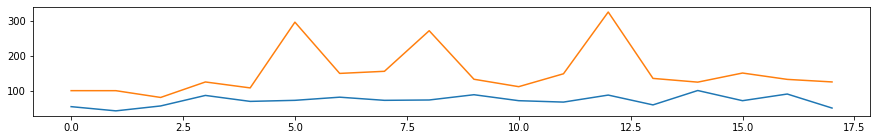

In [438]:
floor = '3F'
plt.figure(figsize = (15,2))
plt.plot(globals()[f'oper_{floor}'])
plt.plot(globals()[f'pred_{floor}'])
# plt.plot(globals()[f'error_{floor}'])
plt.show()

In [426]:
min(error_2F)

3.6999999999999886

In [427]:
max(error_2F)

141.53333333333333

In [437]:
floor = '3F'

valid_df = globals()[f'valid_df_{floor}'].copy()

test_x_values = globals()[f'test_x_{floor}'].values
test_x_values = np.reshape(test_x_values, (test_x_values.shape[0], test_x_values.shape[1], -1))        
model = load_model('lstm_model.h5', compile = False)
pred = model.predict(test_x_values)
pred = pd.DataFrame(index = globals()[f'test_x_{floor}'].index, data = pred.reshape(pred.shape[0],pred.shape[1]))
pred = pred.T

globals()[f'oper_{floor}'] = []
globals()[f'pred_{floor}'] = []
globals()[f'error_{floor}'] = []

for col in list(pred):
    print(col)
    temp_df = pred[[col]].copy()
    temp_df.rename(columns = {col : 'temper'}, inplace = True)
    temp_df['time'] = pd.date_range(col, periods=96, freq='15min')
    temp_df['temper_raise'] = np.where(temp_df['temper'] - temp_df['temper'].shift(1) > 0, 1, 0)
    temp_df['hour'] = temp_df['time'].dt.hour
    
    ## 감소추세 직전 데이터 필터링 (상승 후 감소하는 시점 제외)
    temp_df = temp_df[temp_df['hour'] >= 5].copy()
    temp_df = temp_df[temp_df['temper_raise'] == 1].reset_index(drop = True)
    temp_df['time_diff'] = temp_df['time'] - temp_df['time'].shift(1)
    temp_df['time_diff'] = temp_df['time_diff'].astype("timedelta64[m]")
    if temp_df[temp_df['time_diff'] > 15].shape[0] > 0:
        temp_df = temp_df[temp_df['time'] < temp_df[temp_df['time_diff'] > 15]['time'].min()]     
    
    temp_df['temper'] = round(temp_df['temper'],2)
    ## Performance Check
    temp_valid = valid_df[valid_df['날짜'] == col]            
    print(get_time(temp_valid['목표온도'].values[0], temp_df))
    print(get_time(temp_valid['시작온도'].values[0], temp_df))    
    diff = datetime.datetime.strptime(str(get_time(temp_valid['목표온도'].values[0], temp_df))[:19],"%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(str(get_time(temp_valid['시작온도'].values[0], temp_df))[:19],"%Y-%m-%d %H:%M:%S")

    # print("\n")
    pred_time = diff.total_seconds() / 60
    oper_time = temp_valid['가동시간'].values[0]
    globals()[f'oper_{floor}'].append(oper_time)
    globals()[f'pred_{floor}'].append(pred_time)
    globals()[f'error_{floor}'].append(oper_time - pred_time)
    print(f"prediction time : {pred_time}")
    print(f"operation time : {oper_time}")
    print(f"error : {abs(oper_time - pred_time)} \n")

2022-12-07 00:00:00
2022-12-07 08:26:50.050471
2022-12-07 06:46:14.117816
prediction time : 100.6
operation time : 55.0
error : 45.599999999999994 

2022-12-08 00:00:00
2022-12-08 08:29:21.905077
2022-12-08 06:48:49.999678
prediction time : 100.53333333333333
operation time : 43.0
error : 57.53333333333333 

2022-12-09 00:00:00
2022-12-09 08:29:55.852725
2022-12-09 07:08:42.377799
prediction time : 81.21666666666667
operation time : 57.0
error : 24.21666666666667 

2022-12-12 00:00:00
2022-12-12 08:43:21.562016
2022-12-12 06:37:58.529529
prediction time : 125.38333333333334
operation time : 87.0
error : 38.38333333333334 

2022-12-13 00:00:00
2022-12-13 08:45:49.606065
2022-12-13 06:57:22.500595
prediction time : 108.45
operation time : 70.0
error : 38.45 

2022-12-14 00:00:00
2022-12-14 09:34:52.857308
2022-12-14 04:38:57.094714
prediction time : 295.9166666666667
operation time : 73.0
error : 222.91666666666669 

2022-12-15 00:00:00
2022-12-15 09:00:11.539126
2022-12-15 06:30:25.7135

<ipython-input-412-cb698de35ca6>:14: RuntimeWarning: divide by zero encountered in double_scalars
  add_time = 0 + (1-0) * (now_temper-temp_df.loc[0]['temper']) / (temp_df.loc[1]['temper'] - temp_df.loc[0]['temper'])
<ipython-input-412-cb698de35ca6>:14: RuntimeWarning: divide by zero encountered in double_scalars
  add_time = 0 + (1-0) * (now_temper-temp_df.loc[0]['temper']) / (temp_df.loc[1]['temper'] - temp_df.loc[0]['temper'])


prediction time : 135.53333333333333
operation time : 60.0
error : 75.53333333333333 

2022-12-27 00:00:00
2022-12-27 08:49:59.999237
2022-12-27 06:45:06.081891
prediction time : 124.88333333333334
operation time : 101.0
error : 23.88333333333334 

2022-12-28 00:00:00
2022-12-28 08:34:17.141491
2022-12-28 06:03:25.240174
prediction time : 150.86666666666667
operation time : 72.0
error : 78.86666666666667 

2022-12-29 00:00:00
2022-12-29 08:41:03.158817
2022-12-29 06:28:18.262055
prediction time : 132.75
operation time : 91.0
error : 41.75 

2022-12-30 00:00:00
2022-12-30 08:23:31.765688
2022-12-30 06:18:03.065600
prediction time : 125.46666666666667
operation time : 51.0
error : 74.46666666666667 

